In [2]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.datasets import cifar10
import numpy as np

# Data 분리하고, 정규화히기

In [26]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[np.where(y_train==1)[0],:,:,:]
x_test = x_test[np.where(y_test==1)[0],:,:,:]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [37]:
print('{} {}'.format(x_train.shape, x_test.shape))
print('*'*100)
print('{}\n{}'.format(y_train, y_train.shape))
print('*'*100)
print('{}'.format(np.where(y_train==1)))
print('*'*100)
print('{}({})\n{}'.format(np.where(y_train==1)[0], np.where(y_train==1)[0].shape, np.where(y_train==1)[0][:15]))
print('*'*100)
print('{}({})\n{}'.format(np.where(y_train==1)[1], np.where(y_train==1)[1].shape, np.where(y_train==1)[1][:15]))

(5000, 32, 32, 3) (1000, 32, 32, 3)
****************************************************************************************************
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
(50000, 1)
****************************************************************************************************
(array([    4,     5,    32, ..., 49993, 49998, 49999]), array([0, 0, 0, ..., 0, 0, 0]))
****************************************************************************************************
[    4     5    32 ... 49993 49998 49999]((5000,))
[ 4  5 32 44 45 46 60 61 64 65 75 79 94 96 97]
****************************************************************************************************
[0 0 0 ... 0 0 0]((5000,))
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# 가우시안 노이즈 추가

In [32]:
x_train_n = x_train + 0.5 * np.random.normal(loc=0.0, scale=0.4, size=x_train.shape) 
x_test_n = x_test + 0.5 * np.random.normal(loc=0.0, scale=0.4, size=x_test.shape) 

x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)

In [36]:
print('{} {}'.format(x_train_n.shape, x_test_n.shape))

(5000, 32, 32, 3) (1000, 32, 32, 3)


# 계층 선언

In [56]:
inp_img = Input(shape=(32,32,3))

print('1> input shape : {}'.format(inp_img.get_shape()))
img= Conv2D(32, (3, 3), activation='relu', padding='same')(inp_img)
print('2> Conv2D_1 shape : {}'.format(img.get_shape()))
img = MaxPooling2D((2, 2), padding='same')(img)
print('3> MaxPooling2D shape : {}'.format(img.get_shape()))
img = Conv2D(32, (3, 3), activation='relu', padding='same')(img)
print('3> Conv2D_2 shape : {}'.format(img.get_shape()))
img = UpSampling2D((2, 2))(img)
print('2> UpSampling2D shape : {}'.format(img.get_shape()))
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(img)
print('1> Conv2D_3 shape : {}'.format(decoded.get_shape()))

# 함수형 모델
autoencoder = Model(inp_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

tensorboard = TensorBoard(log_dir='./models/autoencoder',\
              histogram_freq=0, write_graph=True, write_images=True)
model_saver = ModelCheckpoint(
                    filepath='./models/autoencoder/autoencoder_model',\
                     verbose=0, period=2)

autoencoder.fit(x_train_n, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_n, x_test),
                callbacks=[tensorboard, model_saver])

1> input shape : (?, 32, 32, 3)
2> Conv2D_1 shape : (?, 32, 32, 32)
3> MaxPooling2D shape : (?, 16, 16, 32)
3> Conv2D_2 shape : (?, 16, 16, 32)
2> UpSampling2D shape : (?, 32, 32, 32)
1> Conv2D_3 shape : (?, 32, 32, 3)
Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.6252 - val_loss: 0.5827
Epoch 2/10
5000/5000 [==============================] - 14s 3ms/step - loss: 0.5740 - val_loss: 0.5661
Epoch 3/10
5000/5000 [==============================] - 14s 3ms/step - loss: 0.5633 - val_loss: 0.5580
Epoch 4/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.5568 - val_loss: 0.5476
Epoch 5/10
5000/5000 [==============================] - 14s 3ms/step - loss: 0.5528 - val_loss: 0.5482
Epoch 6/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.5496 - val_loss: 0.5465
Epoch 7/10
5000/5000 [==============================] - 14s 3ms/step - loss: 0.5475 - val_loss: 0.5445
Epoch 8/10
5

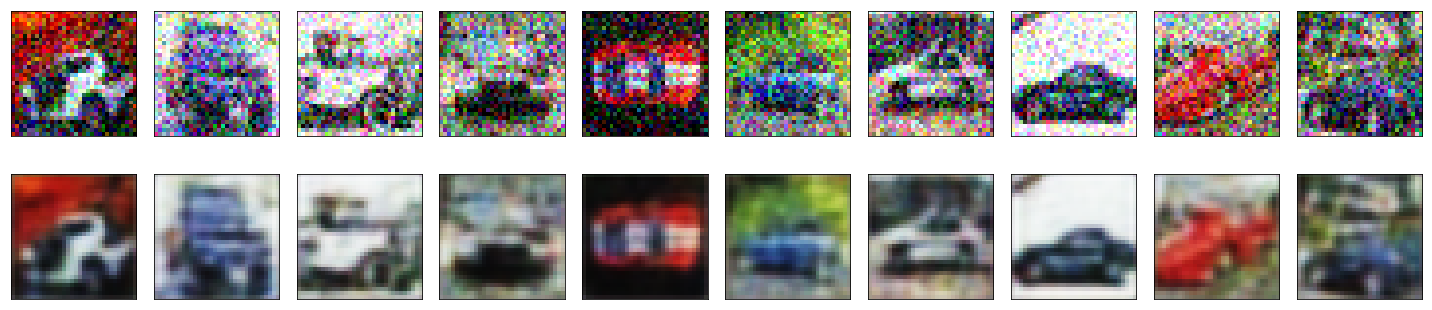

In [57]:
import matplotlib.pyplot as plt
% matplotlib inline

n_imgs = 10
f,axarr = plt.subplots(2,n_imgs,figsize=[20,5])
decoded_imgs = autoencoder.predict(x_test_n)

for i in range(n_imgs):
    
    ax = axarr[0,i]
    ax.get_yaxis().set_visible(False)
    ax.imshow(x_test_n[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = axarr[1,i]
    ax.get_yaxis().set_visible(False)
    ax.imshow(decoded_imgs[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
            
plt.tight_layout()
plt.show()